Hunter Bennett  
Glass Lab  
171211

Notebook for exploration of WGCNA R package using the liver strains data. Following the tutorial PDF for the WGCNA package found here:  

https://labs.genetics.ucla.edu/horvath/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/index.html

In [1]:
getwd()

[1] "/gpfs/data01/glasslab/home/h1bennet/liverStrains/results"

In [2]:
outdir <- '180117_WGCNA/'

In [3]:
library(WGCNA)

Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust

Warning message:
“replacing previous import ‘stats::sd’ by ‘BiocGenerics::sd’ when loading ‘S4Vectors’”Warning message:
“replacing previous import ‘stats::var’ by ‘BiocGenerics::var’ when loading ‘S4Vectors’”Warning message:
“multiple methods tables found for ‘var’”Warning message:
“multiple methods tables found for ‘sd’”Warning message:
“multiple methods tables found for ‘rowSums’”Warning message:
“multiple methods tables found for ‘colSums’”Warning message:
“multiple methods tables found for ‘rowMeans’”Warning message:
“multiple methods tables found for ‘colMeans’”Warning message:
“replacing previous import ‘BiocGenerics::rowSums’ by ‘S4Vectors::rowSums’ when loading ‘AnnotationDbi’”Warning message:
“replacing previous import ‘BiocGenerics::var’ by ‘S4Vectors::var’ when loading ‘AnnotationDbi’”Warning messa

*
*  Package WGCNA 1.51 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=56
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=56
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*





Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor



In [4]:
options(stringsAsFactors = FALSE)
liverData = read.csv('/home/h1bennet/liverStrains/results/180111_RNA_Seq/rnaseq_matrix_condenseGenes_exons_raw_kupffer_mat_deseq.txt',
                    sep='\t')

In [5]:
dim(liverData)

[1] 23192    16

In [6]:
datExpr0 = as.data.frame(t(liverData));
datExpr0 = datExpr0[-1,]
names(datExpr0) <- liverData[,1]

In [7]:
#convert to numeric
datExpr0 <- sapply(datExpr0, as.numeric)

In [8]:
rownames(datExpr0) <- names(liverData[,-1])

In [9]:
dim(datExpr0)

[1]    15 23192

In [10]:
# check samples to see if we have too many missing values
gsg = goodSamplesGenes(datExpr0, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 4611 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

In [11]:
# remove samples or genes with too much missing data
if (!gsg$allOK)
{
# Optionally, print the gene and sample names that were removed:
if (sum(!gsg$goodGenes)>0)
printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")));
if (sum(!gsg$goodSamples)>0)
printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")));
# Remove the offending genes and samples from the data:
datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

Removing genes: 


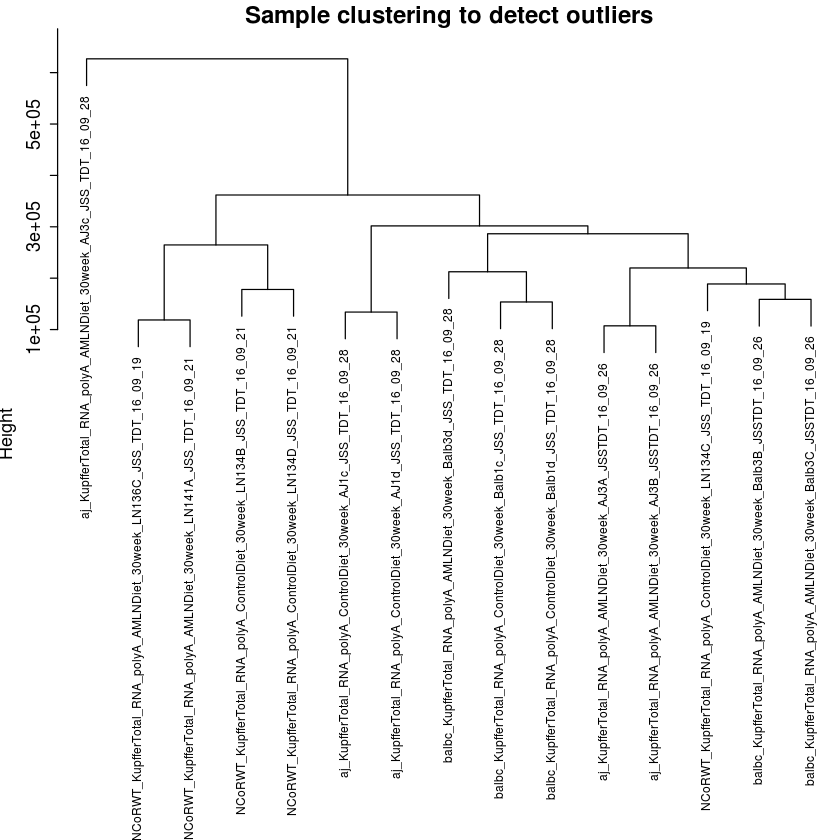

In [12]:
# cluster samples to see if we have outliers
sampleTree = hclust(dist(datExpr0), method = "average");
# Plot the sample tree: Open a graphic output window of size 12 by 9 inches
# The user should change the dimensions if the window is too large or too small.|
#pdf(file = "Plots/sampleClustering.pdf", width = 12, height = 9);
par(cex = 0.6);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
    cex.axis = 1.5, cex.main = 2)

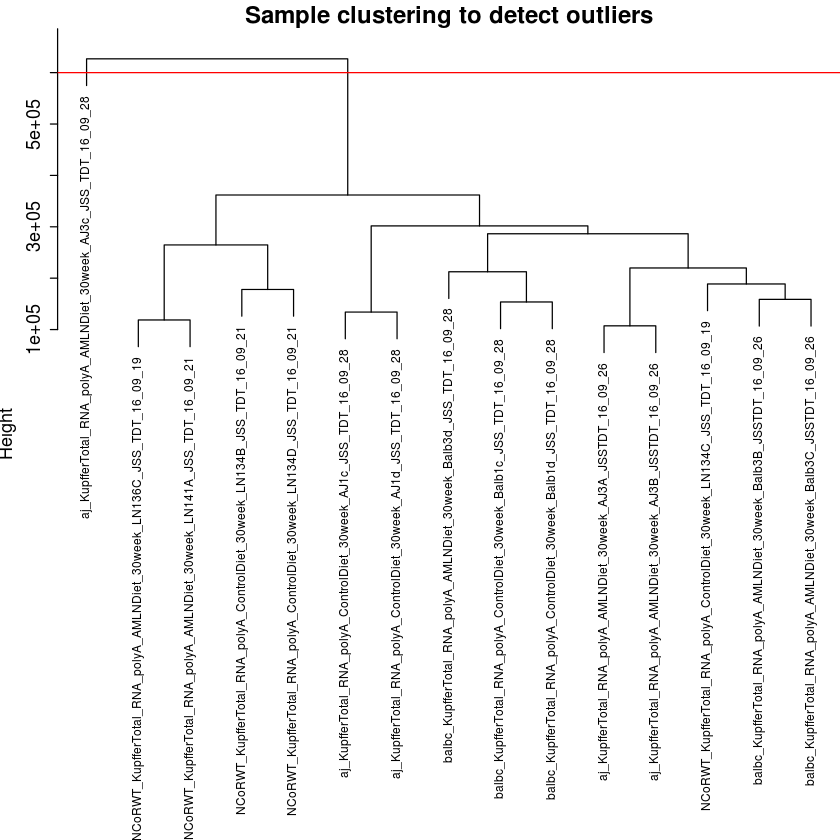

In [13]:
# yet again it looks like 3A is an outlier, we will exclude it by cutting the tree at 40000
par(cex = 0.6);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5,
    cex.axis = 1.5, cex.main = 2)
abline(h = 600000, col = "red");

In [14]:
# Determine cluster under the line
clust = cutreeStatic(sampleTree, cutHeight = 600000, minSize = 10)
table(clust)
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)
datExpr = datExpr0[keepSamples, ]
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

clust
 0  1 
 1 14 

In [15]:
# now we load in the "clinical trait data"
traitData = read.csv('/home/h1bennet/liverStrains/results/171208_RNA_Seq/amln_samples.txt',
                    sep='\t')
dim(traitData)
names(traitData)

[1] 34 11

[1] "X"            "subject"      "sample_type"  "path"         "batch"       
 [6] "strain"       "diet"         "group"        "group_tissue" "exclusion"   
[11] "color"

In [16]:
# remove unneeded traits
allTraits = traitData[, -c(1, 4, 10)];
kup = (traitData$sample_type=='kupffer')
allTraits = allTraits[kup,]
# remove 3A
allTraits = allTraits[-6,]

In [17]:
# make data frame matching expression set that holds clinical traits
kupSamples = gsub('\\.FPKM', '', rownames(datExpr));
traitRows = match(kupSamples, allTraits$subject);
datTraits = allTraits[traitRows, -1];
rownames(datTraits) = allTraits[traitRows, 1];

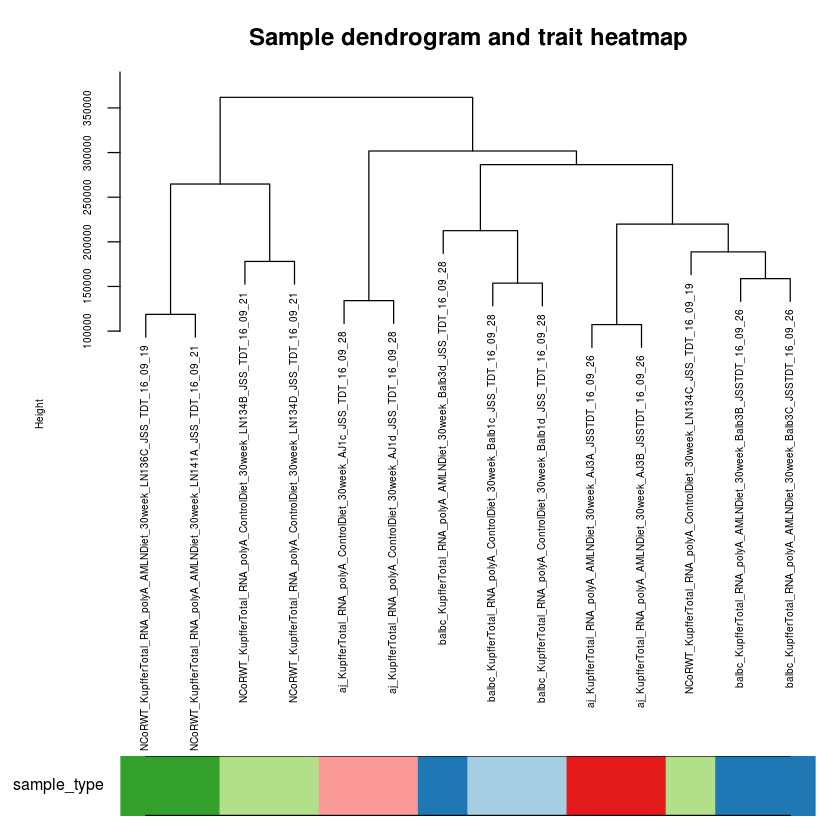

In [18]:
# Re-cluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = datTraits$color;
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap",
                    xlab="", cex.lab = 0.5,
                    cex.axis = 0.5, cex.dendroLabels=0.5,
                    autoColorHeight = FALSE, colorHeight = 0.1)

In [19]:
save(datExpr, datTraits, file = paste0(outdir,"amlnKupffer-01-dataInput.RData"))

In [20]:
# if starting here..
lnames = load(file = paste0(outdir,"amlnKupffer-01-dataInput.RData"));

In [21]:
# Do initial WGCNA analysis
# enable multithreads
enableWGCNAThreads(nThreads=16)

Allowing parallel execution with up to 16 working processes.


pickSoftThreshold: will use block size 2407.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2407 of 18581
   ..working on genes 2408 through 4814 of 18581
   ..working on genes 4815 through 7221 of 18581
   ..working on genes 7222 through 9628 of 18581
   ..working on genes 9629 through 12035 of 18581
   ..working on genes 12036 through 14442 of 18581
   ..working on genes 14443 through 16849 of 18581
   ..working on genes 16850 through 18581 of 18581


Warning message in as.vector(log10(dk)):
“NaNs produced”Warning message in as.vector(log10(dk)):
“NaNs produced”

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.825 12.300          0.843  5420.0    5450.0   7600
2      2    0.269  1.150          0.863  2420.0    2350.0   4340
3      3    0.301  0.562          0.977  1330.0    1210.0   2860
4      4    0.111 -0.290          0.856   825.0     713.0   2090
5      5    0.517 -0.744          0.895   557.0     453.0   1650
6      6    0.701 -0.998          0.931   398.0     306.0   1360
7      7    0.792 -1.170          0.954   298.0     218.0   1150
8      8    0.825 -1.310          0.963   230.0     159.0   1000
9      9    0.848 -1.400          0.971   182.0     118.0    886
10    10    0.860 -1.480          0.974   148.0      92.9    791
11    12    0.867 -1.580          0.972   102.0      60.2    647
12    14    0.878 -1.640          0.980    74.6      39.6    544
13    16    0.878 -1.670          0.980    56.6      26.9    465
14    18    0.875 -1.690          0.977    44.4      18.7    404
15    20    0.871 -1.700 

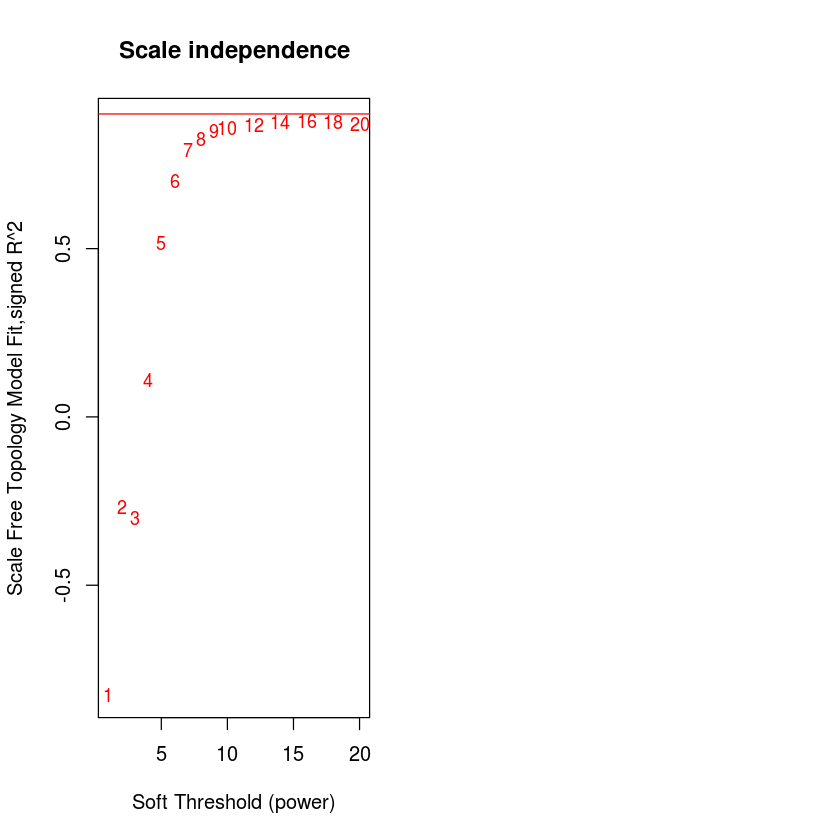

In [24]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)
# Plot the results:
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

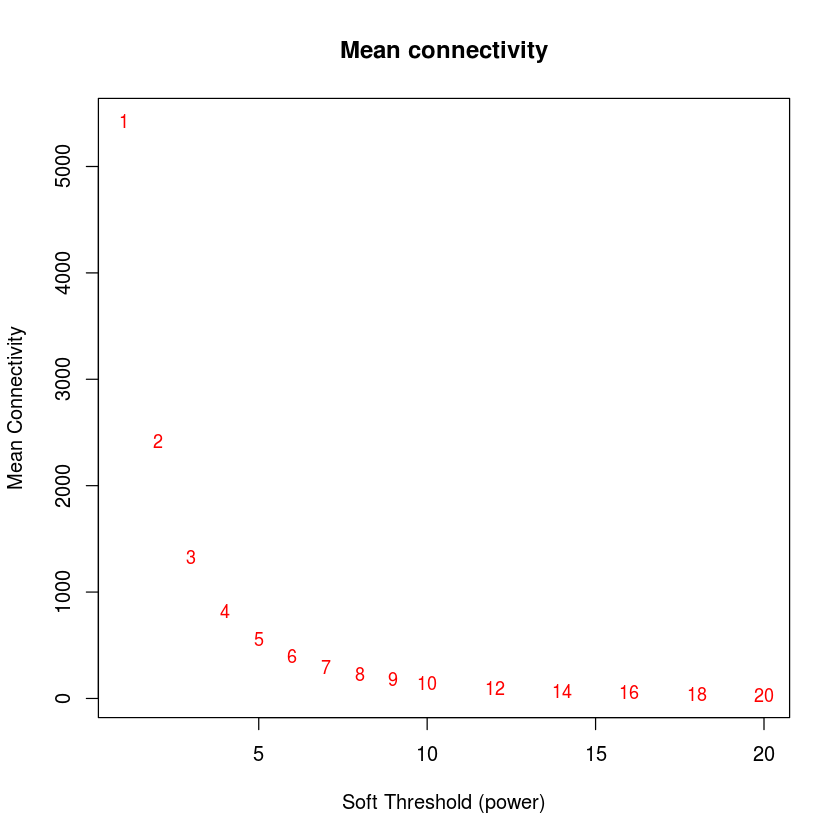

In [25]:
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [ ]:
# currently we are just running this 'out of the box' settings except for a higher max block
# can use more blocks because we have a cluster with sig more RAM
net = blockwiseModules(datExpr, power = 20,
                       TOMType = "unsigned", minModuleSize = 250,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       detectCutHeight = 0.99,
                       numericLabels = TRUE, pamStage=TRUE,
                       pamRespectsDendro = FALSE,
                       saveTOMs = TRUE,
                       saveTOMFileBase = paste0(outdir, "kupfferTOM"),
                       verbose = 3,
                       maxBlockSize=20000)

In [22]:
nnames = load(paste0(outdir, "kupfferTOM-block.1.RData"))

In [ ]:
summary(TOM)

In [ ]:
## Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
        "Module colors",
        dendroLabels = FALSE, hang = 0.03,
        addGuide = TRUE, guideHang = 0.05)

In [9]:
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree,
     file = paste0(outdir, "kupfferTOM-02-networkConstruction-auto.RData"))

ERROR: Error in eval(expr, envir, enclos): object 'net' not found


### Now that we have modules we can see if any of them are specifically enriched in certain individuals of interest. In particular we want to see if any are enriched in the specific strains on the AMLN diet versus all the other conditions 
____
Therefore we should go through correlating the vectors with 1's for the strain-diet combo of interest and 0's for the rest with the gene modules and look for the ones that are most significant

In [10]:
# load in the data starting here.
tnames = load(file = paste0(outdir,"kupfferTOM-02-networkConstruction-auto.RData"));

In [11]:
table(moduleColors)

moduleColors
        black          blue         brown          cyan     darkgreen 
          585          1813          1714           354           231 
     darkgrey    darkorange       darkred darkturquoise         green 
          199           191           231           227           968 
  greenyellow          grey        grey60     lightcyan    lightgreen 
          388            82           309           310           297 
  lightyellow       magenta  midnightblue        orange          pink 
          254           397           319           198           500 
       purple           red     royalblue        salmon           tan 
          391           914           251           363           365 
    turquoise         white        yellow 
         5648           135          1025 

In [64]:
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);

In [103]:
# create function for converting categorical variables to numeric
numerize <- function(x) {
    x <- as.numeric(factor(x))
    x <- x -1
    x
}

In [112]:
# fix the datTraits variable
datTraits$aj = as.numeric(datTraits$strain == 'aj')
datTraits$balb = as.numeric(datTraits$strain == 'balbc')
datTraits$ncorwt = as.numeric(datTraits$strain == 'ncorwt')
datTraits$aj_amln = as.numeric(datTraits$group == 'aj-amln')
datTraits$balb_amln = as.numeric(datTraits$group == 'balbc-amln')
datTraits$ncorwt_amln = as.numeric(datTraits$group == 'ncorwt-amln')
datTraitsn <- data.frame(lapply(datTraits[, c(8:13)], numerize))
rownames(datTraitsn) <- rownames(datTraits)

In [113]:
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraitsn, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

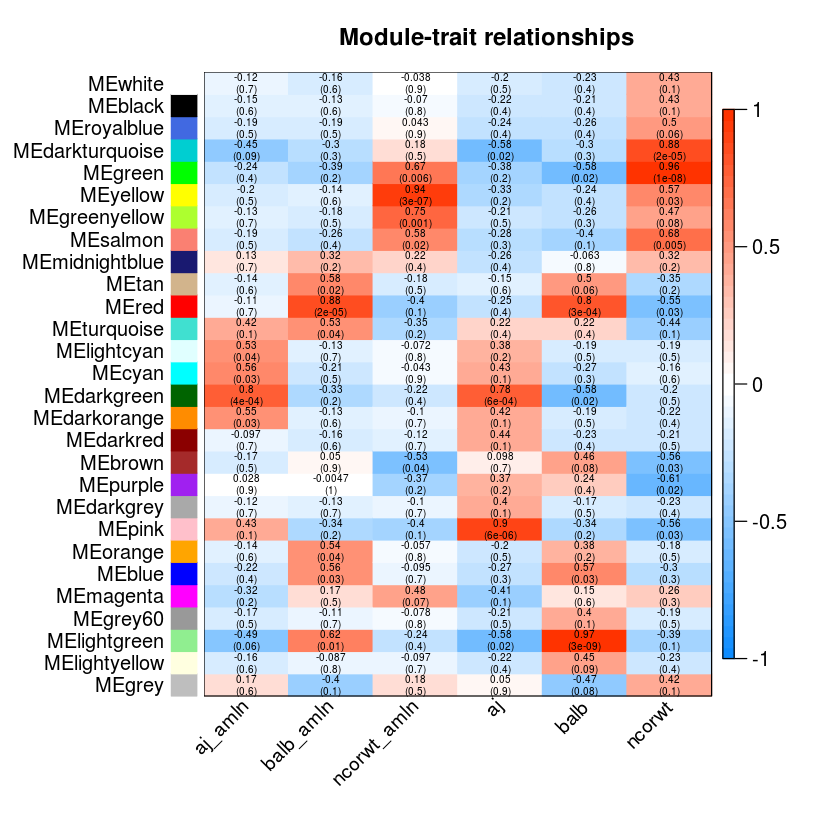

In [114]:
# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
    signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));

labeledHeatmap(Matrix = moduleTraitCor,
    xLabels = names(datTraitsn),
    yLabels = names(MEs),
    ySymbols = names(MEs),
    colorLabels = FALSE,
    colors = blueWhiteRed(50),
    textMatrix = textMatrix,
    setStdMargins = FALSE,
    cex.text = 0.5,
    zlim = c(-1,1),
    main = paste("Module-trait relationships"))

Questions for Inge:
* How do we go about comparing strains and conditions with this analysis?
* Check on the pipeline - am I making any mistakes in the WCGNA analysis?

In [81]:
# Define variable weight containing the weight column of datTrait
strain = as.data.frame(datTraitsn$strain);
names(strain) = "strain"

# names (colors) of the modules
modNames = substring(names(MEs), 3)

geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"));
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));

names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");

geneTraitSignificance = as.data.frame(cor(datExpr, strain, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));

names(geneTraitSignificance) = paste("GS.", names(strain), sep="");
names(GSPvalue) = paste("p.GS.", names(strain), sep="");

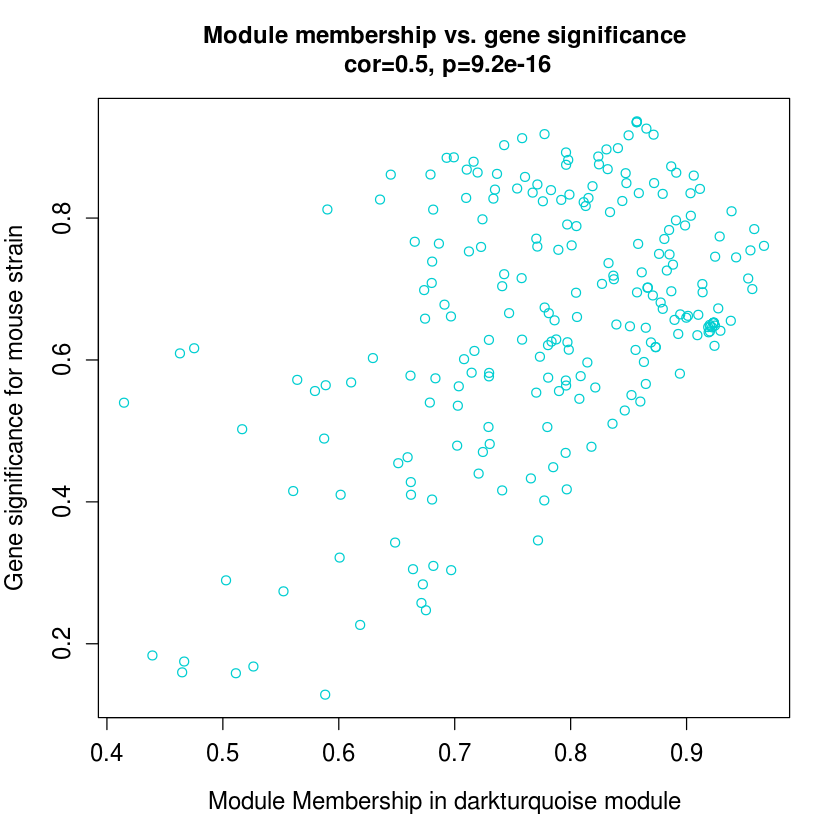

In [88]:
module = "darkturquoise"
column = match(module, modNames);
moduleGenes = moduleColors==module;
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
    abs(geneTraitSignificance[moduleGenes, 1]),
    xlab = paste("Module Membership in", module, "module"),
    ylab = "Gene significance for mouse strain",
    main = paste("Module membership vs. gene significance\n"),
    cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)